## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag

# import gensim
# from gensim import corpora
# from pprint import pprint
# from gensim.models.coherencemodel import CoherenceModel
# import operator

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Opening JSON file 
f = open('/content/drive/MyDrive/AIML/ColabNotebooks/NLP/AutomaticTicketClassificationdataset/complaints.json','r') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
df.shape

(78313, 22)

In [8]:
#Assign new column names
new_columns = [str(col).replace('_source.','') for col in df.columns.to_list()]

In [9]:
new_columns

['_index',
 '_type',
 '_id',
 '_score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [10]:
#removing leading _ from column names
for i,col in enumerate(new_columns):
  if str(col).startswith('_'):
    new_columns[i] = str(col)[1:]
  else:
    new_columns[i] = str(col)
new_columns

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [11]:
df.columns = new_columns

In [12]:
#Assign nan in place of blanks in the complaints column
# def replaceWithNan(x):
#   if(len(str(x)) < 1):
#     return np.nan
#   else:
#     return str(x)

# df['complaint_what_happened'] = df['complaint_what_happened'].swifter.apply(replaceWithNan)

In [13]:
df['complaint_what_happened'].isna().sum()

0

In [14]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened']!=''].reset_index()

In [15]:
df['complaint_what_happened'].isna().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
df['complaint_what_happened'].isna().sum()

0

In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanText(complaint):
  # convert to lower
    complaint = complaint.lower()
    # remove text in sq. bracket
    # search and remove text within square brackets followed by zero or more spaces
    # use non-greedy matching to match all square brackets separately
    complaint = re.sub("\[.*?\]\s*", "", complaint)
    
    # remove punc.
    # create a translation table to remove all punctuations
    complaint = complaint.translate(str.maketrans('', '', string.punctuation))

    # remove words with nos.
    # search and remove digits surrounded by 0 or more alphanumeric chars followed by zero or more spaces
    complaint = re.sub("\w*\d+\w*\s*", "", complaint)
    
    return complaint

In [18]:
# Test the above method on a random complaint

sample = df.complaint_what_happened.sample().values[0]

print(sample)

cleanSample = cleanText(sample)
print(cleanSample)

I received an offer from Chase XXXX Visa promising a companion airline pass XXXX bonus points for opening a Chase XXXX Visa card. I applied for the card online in XX/XX/XXXX providing my current email address, phone number and address. I was approved. In XXXX I requested paperless billing statements/correspondence and assumed that my current contact information provided at time of approval would be utilized by Chase for the XXXX XXXX. 

Having previous Chase credit card products I was able to log into my online account and setup automatic bill payment for my account. I used my card as needed to earn the companion pass and bonus points and assumed the auto payments were being made from my checking account as I viewed line items that had Chase in the description and as I was not receiving paper statements/emails or phone calls from Chase regarding my XXXX account. 

In reviewing my checking account statement in XXXX and realizing the that the Chase line item was actually an auto payment 

In [19]:
#Write your function to Lemmatize the texts

lemmatizer = WordNetLemmatizer()

def lemmatizeText(cleaned_text):
    # tokenize
    tokens = word_tokenize(cleaned_text)

    lemmatized_tokens = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return lemmatized_tokens

In [20]:
# Testing the lemmatize method on random sample

print( "Cleaned Text", "\n")
print(cleanSample)
print("Lemmatized Text","\n")
lemmatizedText=lemmatizeText(cleanSample)
print(lemmatizedText)

Cleaned Text 

i received an offer from chase xxxx visa promising a companion airline pass xxxx bonus points for opening a chase xxxx visa card i applied for the card online in xxxxxxxx providing my current email address phone number and address i was approved in xxxx i requested paperless billing statementscorrespondence and assumed that my current contact information provided at time of approval would be utilized by chase for the xxxx xxxx 

having previous chase credit card products i was able to log into my online account and setup automatic bill payment for my account i used my card as needed to earn the companion pass and bonus points and assumed the auto payments were being made from my checking account as i viewed line items that had chase in the description and as i was not receiving paper statementsemails or phone calls from chase regarding my xxxx account 

in reviewing my checking account statement in xxxx and realizing the that the chase line item was actually an auto paym

In [21]:
!pip install swifter
import swifter

In [22]:
import swifter

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()

df_clean['complaint_what_happened '] = df['complaint_what_happened']
df_clean['complaint'] = df['complaint_what_happened'].swifter.apply(cleanText)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [24]:
df_clean['lemmatized_complaint'] = df_clean.complaint.swifter.apply(lemmatizeText)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [25]:
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [26]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 61.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [27]:
import en_core_web_md

In [28]:
#nlp = spacy.load("en_core_web_md",disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_md',disable=['parser', 'ner'])

In [29]:
#Write your function to extract the POS tags 

def check_pos_tag(text):
  # write your code here
  # extract NOUN POS, ignore all other POS
    
    doc = nlp(text)
    words_without_nouns = []
    for tok in doc:
      #print('pos_tag - '+tok.pos_+'| text - '+tok.text)
      if tok.pos_ in ["NOUN"]:
        words_without_nouns.append(tok.text)
        words_without_nouns.append(' ')

    return ''.join(words_without_nouns)

In [30]:
# Test above method on sample

sample = df_clean.complaint.values[11]
print("Pre Processed","\n")
print(sample)
print( "\n", "Extracted","\n")
extracted = check_pos_tag(sample)
print(extracted)

Pre Processed 

i have reached out to xxxx several times in attempt to have this fraudulent inquiry removed i was told that i need to call and contact the original creditor that placed this inquiry on my report i have made several attempts to get chase bank to contact the bureau and remove this inquiry that was not authorized by me they seem to not be able to get me to the right person to take care of this issue no matter how many attempts i have made nobody seems to understand what im talkin about i want chase bank to have this fraudulent inquiry removed from my credit report before i take legal action i i have never requested any kind of credit with chase bank or hold any account with them i have an iquiry from i want this matter resolved

 Extracted 

xxxx times attempt inquiry creditor inquiry report attempts bureau inquiry person care issue attempts inquiry credit report action kind credit account iquiry matter 


In [31]:
df_clean["complaint_POS_removed"] = df_clean.lemmatized_complaint.swifter.apply(check_pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [32]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




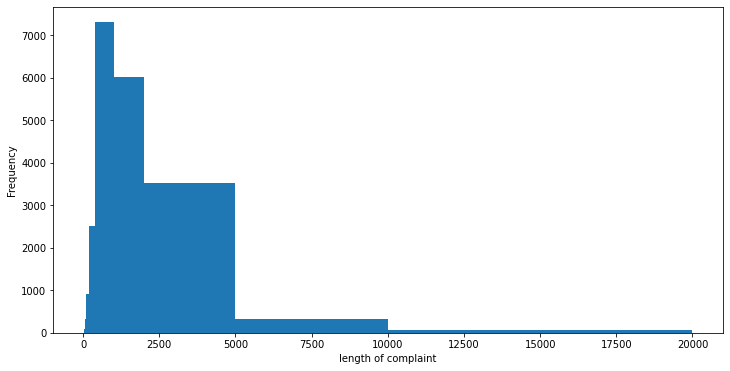

In [33]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.xlabel("length of complaint")
df_clean['complaint'].str.len().plot(
    kind='hist', 
    bins=[20,50,100,200,400,1000,2000,5000,10000,20000],
    figsize=(12,6)
)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [34]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
complaints = ' '.join(df_clean['complaint_POS_removed'])
# replace all occurences of xx..x by a single x and add it as stop word
complaints = re.sub("x{2,}", "x", complaints)

In [35]:
# pip install stopwords

In [36]:
from wordcloud import WordCloud, STOPWORDS

In [37]:
stopwords = STOPWORDS
stopwords.add('x')


In [38]:
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...


In [39]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=40).generate(complaints)

In [40]:
from matplotlib import rcParams
import matplotlib.cm as cm

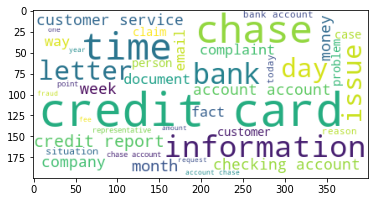

In [41]:
plt.imshow(wordcloud)

plt.show()

In [42]:
# print top 40 words
wordcloud.words_

{'account account': 0.23506334286881897,
 'account chase': 0.17825909276665305,
 'amount': 0.16894156109521863,
 'bank': 0.381610134859011,
 'bank account': 0.18626890069472823,
 'case': 0.19444217409072334,
 'chase': 0.7456477319166326,
 'chase account': 0.17923988557417245,
 'checking account': 0.26252554147936247,
 'claim': 0.19313445034736412,
 'company': 0.2536166734777278,
 'complaint': 0.2123416428279526,
 'credit card': 1.0,
 'credit report': 0.3105026563138537,
 'customer': 0.19207192480588475,
 'customer service': 0.2410298324478954,
 'day': 0.3257866775643645,
 'document': 0.2120147118921128,
 'email': 0.2030241111565182,
 'fact': 0.1993461381283204,
 'fee': 0.17294646505925623,
 'fraud': 0.16828769922353903,
 'information': 0.42721700040866367,
 'issue': 0.3326522272170004,
 'letter': 0.3454842664487127,
 'money': 0.23563547200653862,
 'month': 0.28459337964854925,
 'one': 0.16460972619534123,
 'person': 0.19803841438496117,
 'point': 0.17940335104209235,
 'problem': 0.1904

In [43]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [44]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
import nltk, re, string, collections
from nltk.util import ngrams


In [45]:
# replace previously converted 'x' by empty string
complaints = complaints.replace('x','')

tokenized = complaints.split()
unigrams = ngrams(tokenized, 1)

unigrams_freq = collections.Counter(unigrams)

In [46]:
# print top 30 unigrams along with their counts
for word in unigrams_freq.most_common(30):
  print(f"{word[0][0]}: {word[1]}")

account: 47118
chase: 31741
credit: 31524
card: 28808
payment: 21085
bank: 16964
time: 15958
day: 12672
charge: 12017
money: 11933
loan: 10470
check: 10163
letter: 9605
information: 9581
fee: 8816
number: 8548
transaction: 8523
month: 8454
amount: 8286
year: 8123
customer: 8093
mortgage: 7877
balance: 7633
phone: 7476
company: 7337
fund: 6892
report: 6863
service: 6855
claim: 6783
call: 6578


In [47]:
#Print the top 10 words in the unigram frequency
for word in unigrams_freq.most_common(10):
  print(f"{word[0][0]}: {word[1]}")


account: 47118
chase: 31741
credit: 31524
card: 28808
payment: 21085
bank: 16964
time: 15958
day: 12672
charge: 12017
money: 11933


In [48]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigrams = ngrams(tokenized, 2)

bigrams_freq = collections.Counter(bigrams)

# print top 30 bigrams along with their counts
for word in bigrams_freq.most_common(30):
  print(f"{word[0]}: {word[1]}")


('credit', 'card'): 12234
('credit', 'report'): 3801
('checking', 'account'): 3212
('customer', 'service'): 2949
('account', 'account'): 2863
('bank', 'account'): 2278
('chase', 'account'): 2191
('account', 'chase'): 2174
('chase', 'credit'): 1884
('debit', 'card'): 1799
('account', 'credit'): 1728
('card', 'account'): 1709
('credit', 'score'): 1705
('payment', 'payment'): 1697
('phone', 'call'): 1646
('money', 'account'): 1461
('card', 'card'): 1353
('interest', 'rate'): 1296
('card', 'credit'): 1261
('phone', 'number'): 1248
('account', 'number'): 1212
('business', 'day'): 1151
('account', 'bank'): 1124
('charge', 'account'): 1103
('fund', 'account'): 1079
('chase', 'card'): 1079
('mortgage', 'payment'): 1052
('saving', 'account'): 1037
('account', 'balance'): 1016
('payment', 'account'): 1009


In [49]:
#Print the top 10 words in the bigram frequency
for word in bigrams_freq.most_common(10):
  print(f"{word[0]}: {word[1]}")

('credit', 'card'): 12234
('credit', 'report'): 3801
('checking', 'account'): 3212
('customer', 'service'): 2949
('account', 'account'): 2863
('bank', 'account'): 2278
('chase', 'account'): 2191
('account', 'chase'): 2174
('chase', 'credit'): 1884
('debit', 'card'): 1799


In [50]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(tokenized, 3)

trigrams_freq = collections.Counter(trigrams)

# print top 30 trigrams along with their counts
for word in trigrams_freq.most_common(30):
  print(f"{word[0]}: {word[1]}") 


('chase', 'credit', 'card'): 1267
('credit', 'card', 'account'): 1044
('credit', 'card', 'company'): 839
('credit', 'card', 'credit'): 628
('account', 'credit', 'card'): 560
('inquiry', 'credit', 'report'): 556
('card', 'credit', 'card'): 539
('charge', 'credit', 'card'): 414
('credit', 'report', 'credit'): 403
('chase', 'checking', 'account'): 353
('account', 'credit', 'report'): 346
('credit', 'reporting', 'agency'): 344
('credit', 'card', 'payment'): 340
('chase', 'customer', 'service'): 337
('credit', 'card', 'card'): 336
('credit', 'card', 'chase'): 334
('customer', 'service', 'representative'): 328
('payment', 'credit', 'card'): 292
('credit', 'card', 'balance'): 285
('credit', 'card', 'charge'): 270
('account', 'chase', 'account'): 258
('payment', 'payment', 'payment'): 252
('victim', 'identity', 'theft'): 248
('account', 'checking', 'account'): 241
('credit', 'card', 'year'): 226
('credit', 'card', 'statement'): 219
('account', 'account', 'account'): 209
('bank', 'credit', 'car

In [51]:
#Print the top 10 words in the trigram frequency
for word in trigrams_freq.most_common(10):
  print(f"{word[0]}: {word[1]}") 

('chase', 'credit', 'card'): 1267
('credit', 'card', 'account'): 1044
('credit', 'card', 'company'): 839
('credit', 'card', 'credit'): 628
('account', 'credit', 'card'): 560
('inquiry', 'credit', 'report'): 556
('card', 'credit', 'card'): 539
('charge', 'credit', 'card'): 414
('credit', 'report', 'credit'): 403
('chase', 'checking', 'account'): 353


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [52]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [53]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...,application identity consent service credit id...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...


In [54]:
#df_clean.drop(columns=['Topic'], inplace=True)

In [55]:
# take a backup of the dataframe
df_backup = df_clean.copy()

In [56]:
df_clean = df_backup

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [57]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer


In [58]:
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [59]:
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...,application identity consent service credit id...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...


In [60]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

tfidf_dtm = tfidfvectorizer.fit_transform(df_clean['Complaint_clean'].values)
tfidf_dtm.shape

(21072, 5486)

In [61]:
tfidf_tokens = tfidfvectorizer.get_feature_names()

# print 10 tokens randomly to verify
import random
random.sample(tfidf_tokens, 10)

['folk',
 'redeem',
 'illusion',
 'connectivity',
 'entirety',
 'secuirty',
 'wonder',
 'attendant',
 'treasure',
 'routing']

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [62]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [63]:
#Load your nmf_model with the n_components i.e 5
#write the value you want to test out
num_topics = 15

#keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [64]:
W = nmf_model.fit_transform(tfidf_dtm) # Document-topic matrix
H = nmf_model.components_ # Topic-term matrix

In [65]:
#Print the Top 15 words for each of the topics
words = np.array(tfidfvectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i+1}' for i in range(num_topics)], columns=[f'Word {i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
  ix = H[i].argsort()[::-1][:15]
  topic_words.iloc[i] = words[ix]

In [66]:
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,checking,chase,saving,reason,fund,deposit,business,branch,access,year,activity,identity,report,theft
Topic 2,card,credit,score,limit,year,chase,company,purchase,month,reason,point,application,reward,debit,rate
Topic 3,payment,month,day,credit,time,statement,date,auto,error,chase,car,history,report,plan,issue
Topic 4,inquiry,report,credit,score,company,identity,bureau,information,authorization,application,inquires,theft,date,police,verification
Topic 5,loan,modification,rate,home,car,student,document,auto,year,application,lender,process,time,income,chase
Topic 6,check,fund,deposit,day,hold,cashier,bank,branch,business,chase,teller,checking,stop,refund,week
Topic 7,chase,number,phone,information,letter,customer,email,time,service,address,day,complaint,representative,branch,issue
Topic 8,fee,overdraft,year,time,customer,service,fund,dollar,month,day,chase,deposit,item,practice,transaction
Topic 9,charge,fraud,statement,card,purchase,company,chase,month,time,merchant,police,vendor,investigation,billing,service
Topic 10,dispute,merchant,refund,item,company,flight,service,documentation,ticket,letter,response,credit,proof,day,case


In [67]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
  'Topic 2':'Credit card or prepaid card',
  'Topic 4':'Credit inquiry',
  'Topic 5':'Loans',
  'Topic 7':'Customer Service Representative',
  'Topic 9':'Fraud',
  'Topic 10':'Dispute',
  'Topic 11':'Account Services',
  'Topic 12':'Account Balance',
  'Topic 13':'Fraud',
  'Topic 15':'Mortguage'
}

In [68]:
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...,application identity consent service credit id...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...


In [69]:
#Assign the best topic to each of the complaints in Topic Column
W_new = pd.DataFrame(W, columns = [f'Topic {i+1}' for i in range(num_topics)])
W_new['MaxTopic'] = W_new.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W_new.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,MaxTopic
0,0.008969,0.000000,0.003142,0.000000,0.000000,0.001368,0.009709,0.004286,0.002636,0.000000,0.012631,0.010375,0.000000,0.132195,0.000000,None
1,0.008609,0.013215,0.001534,0.000000,0.000354,0.000000,0.012225,0.001241,0.000000,0.005846,0.000000,0.002885,0.000653,0.000000,0.000000,Credit card or prepaid card
2,0.001896,0.011868,0.000000,0.017438,0.001815,0.000000,0.011556,0.001110,0.000000,0.001265,0.000000,0.000000,0.000000,0.006530,0.000000,Credit inquiry
3,0.015812,0.026921,0.000641,0.028774,0.003137,0.000000,0.030684,0.000000,0.000000,0.003868,0.002977,0.005418,0.000000,0.002092,0.000000,Customer Service Representative
4,0.017933,0.000000,0.000561,0.000000,0.000487,0.061157,0.020966,0.000000,0.000000,0.000000,0.064933,0.000000,0.011817,0.000000,0.000737,Account Services


In [70]:
df_clean.shape

(21072, 5)

In [71]:
W_new.shape

(21072, 16)

In [72]:
df_clean.head(10)

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...,application identity consent service credit id...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
5,Can you please remove inquiry,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry
6,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...
7,"During the summer months, I experience a decli...",during the summer months i experience a declin...,during the summer month i experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i made a payment to an online retailer...,on xxxx i made a payment to an online retailer...,payment retailer xxxx chase website scam websi...,payment retailer chase website scam website c...
9,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card data credit report company issue,credit card data credit report company issue


In [73]:
#Print the first 5 Complaint for each of the Topics
df_clean['Topic'] = W_new[['MaxTopic']]
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
286,The following was sent to Chase on XX/XX/2019 ...,the following was sent to chase on insufficien...,the following wa sent to chase on insufficient...,fund fee item detail payment fund fee check xx...,fund fee item detail payment fund fee check a...,Account Balance
140,I purchased a Refrigerator on a store Credit C...,i purchased a refrigerator on a store credit c...,i purchased a refrigerator on a store credit c...,refrigerator store credit card ability cash ad...,refrigerator store credit card ability cash ad...,Account Balance
37,"In XX/XX/2019, several transactions on my Chas...",in several transactions on my chase checking a...,in several transaction on my chase checking ac...,transaction chase checking account report chas...,transaction chase checking account report chas...,Account Balance
173,"XX/XX/2019 Friday, XXXX XXXX, Michigan ( Chase...",friday xxxx xxxx michigan chase xxxx xxxx xx...,friday xxxx xxxx michigan chase xxxx xxxx xxxx...,amount branch amount checking account day char...,amount branch amount checking account day char...,Account Balance
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,i made a purchase of on xxxxxxxx i made paymen...,i made a purchase of on xxxxxxxx i made paymen...,purchase payment xxxxxxxx payment closing date...,purchase payment payment closing date statem...,Account Balance
51,XX/XX/2019 {$200.00} for joining chase bank ch...,for joining chase bank checking and setting up...,for joining chase bank checking and setting up...,deposit deposit deposit bank coupon code link ...,deposit deposit deposit bank coupon code link ...,Account Services
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Account Services
43,I Purchase is an airline ticket on XX/XX/XXXX ...,i purchase is an airline ticket on xxxxxxxx an...,i purchase is an airline ticket on xxxxxxxx an...,airline ticket airport ticket hour refund acco...,airline ticket airport ticket hour refund acco...,Account Services
17,My card went missing and i didnt realize it un...,my card went missing and i didnt realize it un...,my card went missing and i didnt realize it un...,card today email deposit money bank account,card today email deposit money bank account,Account Services
22,My roommate was stealing my Chase debit card a...,my roommate was stealing my chase debit card a...,my roommate wa stealing my chase debit card an...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,Account Services


In [74]:
df_clean[df_clean['Topic'].isna()].head(20)

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,None
6,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,None
7,"During the summer months, I experience a decli...",during the summer months i experience a declin...,during the summer month i experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,None
10,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account,account,None
12,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account code xxxxxxxx term account deposit bon...,account code term account deposit bonus day d...,None
13,"To whom it may concern, Chase bank charged wro...",to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,concern overdraft fee alert balance unsuficent...,concern overdraft fee alert balance unsuficent...,None
15,I opened the saving account for the {$25.00} b...,i opened the saving account for the bonus i wa...,i opened the saving account for the bonus i wa...,saving account bonus bonus auto transfer trans...,saving account bonus bonus auto transfer trans...,None
29,Someone called stating I had felony committed ...,someone called stating i had felony committed ...,someone called stating i had felony committed ...,felony security number name xxxx checking acco...,felony security number name checking account ...,None
33,I recently called to ask Chase bank why they r...,i recently called to ask chase bank why they r...,i recently called to ask chase bank why they r...,credit bureau day payment info xxxx bill xxxx ...,credit bureau day payment info bill balance ...,None
34,UNKNOWN INQUIRE REPORTED ON MY CREDIT BUREAU S...,unknown inquire reported on my credit bureau s...,unknown inquire reported on my credit bureau s...,inquire credit bureau xxxx date company chase ...,inquire credit bureau date company chase auto,None


In [75]:
df_clean.shape

(21072, 6)

In [76]:
df_clean['Topic'].isna().sum()

6485

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [77]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    'Credit card or prepaid card' : 'Credit card or Prepaid card',
    'Credit inquiry' : 'Others',
    'Loans' : 'Mortgages or loans',
    'Customer Service Representative' : 'Others',
    'Fraud' : 'Theft or Dispute reporting',
    'Dispute' : 'Theft or Dispute reporting',
    'Account Services' : 'Bank account services',
    'Account Balance' : 'Bank account services',
    'Mortguage' : 'Mortgages or loans'
    }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [78]:
df_clean

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...,morning name stop service debt verification st...,NaN
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or Prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...,application identity consent service credit id...,Others
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Others
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Bank account services
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or Prepaid card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,Theft or Dispute reporting
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,risk consumer bank app chase year banking merc...,risk consumer bank app chase year banking merc...,Theft or Dispute reporting
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit yr credit card xxxx problem balance tra...,credit yr credit card problem balance transfe...,Bank account services


In [79]:
df_clean.columns = ['complaint_what_happened','complaint','lemmatized_complaint','complaint_POS_removed','Complaint_clean','Topic']

In [80]:
df_clean['complaint'].isna().sum()

0

In [81]:
df_clean['Topic'].isna().sum()

6485

Topic is the target variable for the supervised model which involves classification of complaints to the relevant categories(Topics) . Since we are unable to classify 6485 complaints into categories we will be dropping those rows from the dataset.

In [82]:
df_clean = df_clean[~df_clean['Topic'].isna()]

In [83]:
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Bank account services
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,i made a purchase of on xxxxxxxx i made paymen...,i made a purchase of on xxxxxxxx i made paymen...,purchase payment xxxxxxxx payment closing date...,purchase payment payment closing date statem...,Bank account services
17,My card went missing and i didnt realize it un...,my card went missing and i didnt realize it un...,my card went missing and i didnt realize it un...,card today email deposit money bank account,card today email deposit money bank account,Bank account services
37,"In XX/XX/2019, several transactions on my Chas...",in several transactions on my chase checking a...,in several transaction on my chase checking ac...,transaction chase checking account report chas...,transaction chase checking account report chas...,Bank account services
22,My roommate was stealing my Chase debit card a...,my roommate was stealing my chase debit card a...,my roommate wa stealing my chase debit card an...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,Bank account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or Prepaid card
28,I opened the Chase/XXXX XXXX Rewards credit ca...,i opened the chasexxxx xxxx rewards credit car...,i opened the chasexxxx xxxx reward credit card...,credit card time offer reward point companion ...,credit card time offer reward point companion ...,Credit card or Prepaid card
9,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,credit card data credit report company issue,credit card data credit report company issue,Credit card or Prepaid card
27,Chase is marketing credit cards to those of us...,chase is marketing credit cards to those of us...,chase is marketing credit card to those of u w...,credit card credit style marketing card online...,credit card credit style marketing card online...,Credit card or Prepaid card
14,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,catering order brother funeral amount chase no...,catering order brother funeral amount chase no...,Credit card or Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [84]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank account services' : 0,
               'Credit card or Prepaid card' : 1,
               'Theft or Dispute reporting' : 2,
               'Mortgages or loans' : 3,
               'Others' : 4
               }
#Replace Topics with Topic Names

def convertTopics(topic):
  return Topic_names.get(topic)

df_clean['NewTopic'] = df_clean['Topic'].apply(convertTopics)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [85]:
df_clean.head()

,complaint_what_happened,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic,NewTopic
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or Prepaid card,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,application identity consent service credit id...,application identity consent service credit id...,Others,4
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i...,on while trying to book a xxxx xxxx ticket i c...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Others,4
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Bank account services,0
5,Can you please remove inquiry,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Others,4


In [86]:
df_clean['NewTopic'].isna().sum()

0

In [87]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint','NewTopic']]

In [88]:
training_data.columns = ['complaint','NewTopic']

In [89]:
training_data.shape

(14587, 2)

In [90]:
training_data.head()

,complaint,NewTopic
1,i upgraded my xxxx xxxx card in and was told b...,1
2,chase card was reported on however fraudulent ...,4
3,on while trying to book a xxxx xxxx ticket i...,4
4,my grand son give me check for i deposit it in...,0
5,can you please remove inquiry,4


In [91]:
len(training_data['NewTopic'].index)

14587

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [92]:
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold,GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(training_data['complaint'], training_data['NewTopic'], test_size=0.25, random_state=42)

X_test_inference = X_test
y_test_inference = y_test

In [93]:
#Write your code here to transform the word vector to tf-idf
tfidfvectorizer_supervised = TfidfVectorizer(analyzer='word',stop_words='english', max_df=0.95, min_df=2)

X_train = tfidfvectorizer_supervised.fit_transform(X_train)
X_test = tfidfvectorizer_supervised.transform(X_test)

In [94]:
y_train.value_counts()

2    3119
3    2279
1    2077
4    1846
0    1619
Name: NewTopic, dtype: int64

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import f1_score

In [96]:
# Write your code here to build any 3 models and evaluate them using the required metrics



**1. LOGISTIC REGRESSION**

In [97]:
lr = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)

f1_score(y_test,y_test_pred, average='micro') #micro since multiclass

0.8919659994516039

**2. DECISION TREE**

In [98]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

params = {
    "max_depth": [3,5,10,20,40,50],
    "min_samples_leaf": [5,10,20,50,100,150]
}

In [99]:
model_cv = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [100]:
model_cv.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20, 40, 50],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 150]},
             scoring='accuracy', verbose=1)

In [101]:
model_cv.best_score_

0.7848263254113346

In [102]:
model_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       random_state=42)

In [103]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10, random_state=42)

In [104]:
dt = dt.fit(X_train,y_train)
y_test_pred = dt.predict(X_test)

f1_score(y_test,y_test_pred, average='micro') #micro since multiclass

0.7981902933918289

**3. RANDOM FOREST**

In [105]:
rfc=RandomForestClassifier(n_estimators=200)

In [106]:
rfc.fit(X_train,y_train)

y_test_pred=rfc.predict(X_test)

In [107]:
f1_score(y_test,y_test_pred, average='micro') #micro since multiclass

0.8294488620784207

As we can see the f1_score seems to be highest for Logistic Regression. Hence, **Logistic Regression** seems to be the best fit for the model.

In [137]:
# Using Logistic Regression to predict a custom text from the test data set to verify the model prediction.
custom_text = X_test_inference.to_numpy()[40]

In [139]:
label = y_test_inference.to_numpy()[40]

In [142]:
custom_text

'i have requested the information reported either be removed or that chase bank show me where i personally requested authorized approved or signed for this credit card i even had my attorney contact them personally and they can not or will not show me this information their only response is  we have looked into this matter and conclude it is accurate  i did not request or authorize this credit card'

i have requested the information reported either be removed or that chase bank show me where i personally requested authorized approved or signed for this **credit card** i even had my attorney contact them personally and they can not or will not show me this information their only response is  we have looked into this matter and conclude it is accurate  i did not request or authorize this **credit card**

In [144]:
label

1

'Bank account services' : 0,
'Credit card or Prepaid card' : 1,
'Theft or Dispute reporting' : 2,
'Mortgages or loans' : 3,
'Others' : 4

In [146]:
lr.predict(X_test[40])

array([1])

Hence, the sample ticket will be classified to **Credit card or Prepaid card**